In [1]:
import setGPU
import os
import numpy as np
from collections import namedtuple
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print('tensorflow version: ', tf.__version__)
import setGPU
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../../')))

import vae.vae_particle as vap
import vae.losses as losses
import pofah.util.experiment as expe
import pofah.util.sample_factory as safa
import util.data_generator as dage
import sarewt.data_reader as dare
import pofah.phase_space.cut_constants as cuts
import training as tra
import tensorflow.keras.layers as klayers
from importlib import reload


setGPU: Setting GPU to: 0
tensorflow version:  2.3.0


In [2]:
# ********************************************************
#       runtime params
# ********************************************************

Parameters = namedtuple('Parameters', 'run_n input_shape kernel_sz kernel_ini_n beta epochs train_total_n gen_part_n valid_total_n batch_n z_sz activation initializer learning_rate max_lr_decay lambda_reg')
params = Parameters(run_n=113, 
                    input_shape=[(100,2),(100,3)],
                    kernel_sz=(1,3), 
                    kernel_ini_n=12,
                    beta=0.1, 
                    epochs=20, 
                    train_total_n=int(10e3), 
                    valid_total_n=int(10e3), 
                    gen_part_n=int(5e4), 
                    batch_n=256, 
                    z_sz=12,
                    activation='elu',
                    initializer='he_uniform',
                    learning_rate=0.001,
                    max_lr_decay=8, 
                    lambda_reg=0.0) # 'L1L2'



In [5]:
nodes_n=100
feat_sz=3

In [6]:
import tensorflow.keras.layers as klayers


class _DotDict:
    pass

setting = _DotDict()
setting.name = 'PN'
 # conv_params: list of tuple in the format (K, (C1, C2, C3))
setting.conv_params = [
   (15, ([20,20,20])),
  #      (7, (32, 32, 32)),
  #      (7, (64, 64, 64)),
        ]
#setting.conv_params_decoder = [60,32,16,8, 5]
setting.conv_params_encoder_input = 20 #64 #20
setting.conv_params_encoder = []
setting.conv_params_decoder = [10]  #[32,16,8]
setting.with_bn = True
# conv_pooling: 'average' or 'max' #indeed average seems to perform better
setting.conv_pooling = 'average'
setting.conv_linking = 'sum' #concat or sum
setting.num_points = nodes_n #num of original consituents
setting.num_features = feat_sz #num of original features
setting.input_shapes = {'points': [nodes_n,feat_sz-1],'features':[nodes_n,feat_sz]}
setting.latent_dim = 3
setting.ae_type = 'vae'  #ae or vae 
setting.kl_warmup_time = 10
setting.activation = klayers.LeakyReLU(alpha=0.1)


In [7]:
import vae.vae_base as vae_base
reload(vae_base)
import vae.vae_particlenet as vae_pn
reload(vae_pn)

vae = vae_pn.VAE_ParticleNet(beta=params.beta,setting=setting,kernel_ini_n=params.kernel_ini_n,name='PN_AE_',input_shape=params.input_shape)
a = [1]
vae.build(a)
#


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 100, 2)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_Transpose (TensorFl [(None, 2, 100)]     0           points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Mul (TensorFlowOpLa [(None, 100, 2)]     0           points[0][0]                     
                                                                 points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_BatchMatMulV2 (Tens [(None, 100, 100)]   0           points[0][0]               

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input_0 (InputLayer)      [(None, 100, 2)]     0                                            
__________________________________________________________________________________________________
model_input_1 (InputLayer)      [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 3), (None, 3 13106       model_input_0[0][0]              
                                                                 model_input_1[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 100, 3)       8033        encoder[0][0]                  

In [8]:
# *******************************************************
#                       training options
# *******************************************************

optimizer = tf.keras.optimizers.Adam(learning_rate=params.learning_rate)
loss_fn = losses.threeD_loss

In [27]:
import h5py

import ADgvae.utils.preprocessing as prepr
reload(prepr)

DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/input/'
#filename_bg = DATA_PATH + 'QCD_training_data_02_08_2021.h5'
filename_bg = DATA_PATH + 'QCD_training_data_100const_03_08_2021.h5'
inFile = h5py.File(filename_bg, 'r')
particles_bg = inFile['particle_bg'][0:int(5*10e4)]
particles_bg_valid = inFile['particle_bg_valid'][0:int(1*10e4)]
particles_bg_test = inFile['particle_bg_test'][0:int(1*10e4)]
nodes_n = particles_bg.shape[1]
feat_sz = particles_bg.shape[2]

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((particles_bg[:10000,:,0:2],particles_bg[:10000,:,:]))

batched_dataset = train_ds.batch(256)
#for step, x_batch_train in enumerate(batched_dataset):
#    print(x_batch_train)
#    break

In [9]:
import pofah.path_constants.sample_dict_file_parts_input_vae as sdi
reload(sdi)

experiment = expe.Experiment(params.run_n).setup(model_dir=True, fig_dir=True)
paths = safa.SamplePathDirFactory(sdi.path_dict)

# train (generator)
print('>>> Preparing training dataset generator')

reload(expe)
reload(safa)

import util.data_generator_particlenet as dage_pn
reload(dage_pn)



>>> Preparing training dataset generator


<module 'util.data_generator_particlenet' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/data_generator_particlenet.py'>

In [10]:
#data_train_generator_new = dage_pn.DataGeneratorDirect(path=paths.sample_dir_path('qcdSide'), 
#                                          sample_part_n=params.gen_part_n, 
#                                         sample_max_n=params.train_total_n, 
#                                          batch_size = 256,
 #                                         **cuts.global_cuts) # generate 10 M jet samples

path = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based/test_0.h5'
data_train_generator_new = dage_pn.DataGeneratorDirectPrepr(path=path,sample_max_n=params.train_total_n, 
                                          batch_size = 256)

In [42]:
import h5py
import tensorflow as tf

class generator:
    def __call__(self, file,sample_max_n):
        samples_read_n = 0
        with h5py.File(file, 'r')as inFile:
            samples = inFile['particle_bg']

            batch_size = 256
            nb = samples.shape[0] // batch_size
            last_batch = samples.shape[0] % batch_size

            for ib in range(nb):
                samples_read_n += batch_size
                if sample_max_n is not None and (samples_read_n >= sample_max_n+batch_size):
                    break
                else :
                    yield samples[ib*batch_size:(ib+1)*batch_size,:,0:2], samples[ib*batch_size:(ib+1)*batch_size,:,:]
            if last_batch > 0:
                yield samples[-last_batch:,:,0:2], samples[-last_batch:,:,:]
                
                
                

filenames = [path]
ds = tf.data.Dataset.from_tensor_slices(filenames)
ds = ds.interleave(lambda filename: tf.data.Dataset.from_generator(
        generator(), 
        (tf.float32,tf.float32), 
        (tf.TensorShape([None,100,2]), tf.TensorShape([None,100,3])),
        args=(filename,params.train_total_n,)))
batched_dataset = ds

In [44]:
import time

# starting time
start = time.time()

reload(tra)
import setGPU
trainer = tra.TrainerParticleNet(optimizer=optimizer, beta=params.beta, patience=3, min_delta=0.03, max_lr_decay=params.max_lr_decay, lambda_reg=params.lambda_reg)

losses_reco, losses_valid = trainer.train(vae=vae, loss_fn=loss_fn,
                                          train_ds=batched_dataset, valid_ds=batched_dataset,
                                         # train_ds  = data_train_generator_new(),valid_ds=data_train_generator_new(),
                                          epochs=params.epochs, model_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/')

# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")



### [6.8 17:17:44] Start of epoch 0
Step 0: mean reco loss 0.0434, KL loss 0.0218 (in one batch)
Seen so far: 1 samples
Step 1: mean reco loss 0.0452, KL loss 0.0201 (in one batch)
Seen so far: 2 samples
Step 2: mean reco loss 0.0451, KL loss 0.0189 (in one batch)
Seen so far: 3 samples
Step 3: mean reco loss 0.0415, KL loss 0.0193 (in one batch)
Seen so far: 4 samples
Step 4: mean reco loss 0.0431, KL loss 0.0188 (in one batch)
Seen so far: 5 samples
Step 5: mean reco loss 0.0431, KL loss 0.0180 (in one batch)
Seen so far: 6 samples
Step 6: mean reco loss 0.0436, KL loss 0.0187 (in one batch)
Seen so far: 7 samples
Step 7: mean reco loss 0.0425, KL loss 0.0185 (in one batch)
Seen so far: 8 samples
Step 8: mean reco loss 0.0427, KL loss 0.0175 (in one batch)
Seen so far: 9 samples
Step 9: mean reco loss 0.0402, KL loss 0.0193 (in one batch)
Seen so far: 10 samples
Step 10: mean reco loss 0.0413, KL loss 0.0205 (in one batch)
Seen so far: 11 samples
Step 11: mean reco loss 0.0405, KL l

Step 11: mean reco loss 0.0269, KL loss 0.0120 (in one batch)
Seen so far: 12 samples
Step 12: mean reco loss 0.0277, KL loss 0.0119 (in one batch)
Seen so far: 13 samples
Step 13: mean reco loss 0.0267, KL loss 0.0136 (in one batch)
Seen so far: 14 samples
Step 14: mean reco loss 0.0284, KL loss 0.0125 (in one batch)
Seen so far: 15 samples
Step 15: mean reco loss 0.0273, KL loss 0.0118 (in one batch)
Seen so far: 16 samples
Step 16: mean reco loss 0.0266, KL loss 0.0118 (in one batch)
Seen so far: 17 samples
Step 17: mean reco loss 0.0274, KL loss 0.0108 (in one batch)
Seen so far: 18 samples
Step 18: mean reco loss 0.0270, KL loss 0.0114 (in one batch)
Seen so far: 19 samples
Step 19: mean reco loss 0.0269, KL loss 0.0117 (in one batch)
Seen so far: 20 samples
Step 20: mean reco loss 0.0266, KL loss 0.0120 (in one batch)
Seen so far: 21 samples
Step 21: mean reco loss 0.0259, KL loss 0.0126 (in one batch)
Seen so far: 22 samples
Step 22: mean reco loss 0.0265, KL loss 0.0115 (in one

Step 23: mean reco loss 0.0198, KL loss 0.0089 (in one batch)
Seen so far: 24 samples
Step 24: mean reco loss 0.0202, KL loss 0.0083 (in one batch)
Seen so far: 25 samples
Step 25: mean reco loss 0.0204, KL loss 0.0074 (in one batch)
Seen so far: 26 samples
Step 26: mean reco loss 0.0194, KL loss 0.0081 (in one batch)
Seen so far: 27 samples
Step 27: mean reco loss 0.0200, KL loss 0.0076 (in one batch)
Seen so far: 28 samples
Step 28: mean reco loss 0.0199, KL loss 0.0071 (in one batch)
Seen so far: 29 samples
Step 29: mean reco loss 0.0196, KL loss 0.0083 (in one batch)
Seen so far: 30 samples
Step 30: mean reco loss 0.0199, KL loss 0.0079 (in one batch)
Seen so far: 31 samples
Step 31: mean reco loss 0.0193, KL loss 0.0075 (in one batch)
Seen so far: 32 samples
Step 32: mean reco loss 0.0198, KL loss 0.0077 (in one batch)
Seen so far: 33 samples
Step 33: mean reco loss 0.0199, KL loss 0.0074 (in one batch)
Seen so far: 34 samples
Step 34: mean reco loss 0.0197, KL loss 0.0079 (in one

Step 33: mean reco loss 0.0175, KL loss 0.0054 (in one batch)
Seen so far: 34 samples
Step 34: mean reco loss 0.0179, KL loss 0.0060 (in one batch)
Seen so far: 35 samples
Step 35: mean reco loss 0.0169, KL loss 0.0058 (in one batch)
Seen so far: 36 samples
Step 36: mean reco loss 0.0173, KL loss 0.0062 (in one batch)
Seen so far: 37 samples
Step 37: mean reco loss 0.0173, KL loss 0.0061 (in one batch)
Seen so far: 38 samples
Step 38: mean reco loss 0.0175, KL loss 0.0057 (in one batch)
Seen so far: 39 samples
Step 39: mean reco loss 0.0167, KL loss 0.0062 (in one batch)
Seen so far: 40 samples
Step 40: mean reco loss 0.0166, KL loss 0.0060 (in one batch)
Seen so far: 41 samples
### [Epoch 6 - 9.19 sec]: train loss reco 0.018 kl 0.006, val loss reco 0.032 kl 0.005 (mean / batch) ###
saving best so far model with valid loss 0.032 and kl loss 0.005
saving model to /eos/user/n/nchernya/MLHEP/AnomalyDetection/best_so_far

### [6.8 17:18:50] Start of epoch 7
Step 0: mean reco loss 0.0174, K

### [Epoch 8 - 8.85 sec]: train loss reco 0.016 kl 0.005, val loss reco 0.024 kl 0.005 (mean / batch) ###
saving best so far model with valid loss 0.024 and kl loss 0.005
saving model to /eos/user/n/nchernya/MLHEP/AnomalyDetection/best_so_far

### [6.8 17:19:9] Start of epoch 9
Step 0: mean reco loss 0.0161, KL loss 0.0050 (in one batch)
Seen so far: 1 samples
Step 1: mean reco loss 0.0160, KL loss 0.0047 (in one batch)
Seen so far: 2 samples
Step 2: mean reco loss 0.0162, KL loss 0.0048 (in one batch)
Seen so far: 3 samples
Step 3: mean reco loss 0.0159, KL loss 0.0051 (in one batch)
Seen so far: 4 samples
Step 4: mean reco loss 0.0164, KL loss 0.0049 (in one batch)
Seen so far: 5 samples
Step 5: mean reco loss 0.0168, KL loss 0.0050 (in one batch)
Seen so far: 6 samples
Step 6: mean reco loss 0.0159, KL loss 0.0044 (in one batch)
Seen so far: 7 samples
Step 7: mean reco loss 0.0162, KL loss 0.0046 (in one batch)
Seen so far: 8 samples
Step 8: mean reco loss 0.0157, KL loss 0.0040 (in

Step 6: mean reco loss 0.0151, KL loss 0.0037 (in one batch)
Seen so far: 7 samples
Step 7: mean reco loss 0.0157, KL loss 0.0041 (in one batch)
Seen so far: 8 samples
Step 8: mean reco loss 0.0152, KL loss 0.0037 (in one batch)
Seen so far: 9 samples
Step 9: mean reco loss 0.0153, KL loss 0.0037 (in one batch)
Seen so far: 10 samples
Step 10: mean reco loss 0.0155, KL loss 0.0035 (in one batch)
Seen so far: 11 samples
Step 11: mean reco loss 0.0154, KL loss 0.0036 (in one batch)
Seen so far: 12 samples
Step 12: mean reco loss 0.0157, KL loss 0.0039 (in one batch)
Seen so far: 13 samples
Step 13: mean reco loss 0.0154, KL loss 0.0043 (in one batch)
Seen so far: 14 samples
Step 14: mean reco loss 0.0150, KL loss 0.0038 (in one batch)
Seen so far: 15 samples
Step 15: mean reco loss 0.0153, KL loss 0.0035 (in one batch)
Seen so far: 16 samples
Step 16: mean reco loss 0.0153, KL loss 0.0037 (in one batch)
Seen so far: 17 samples
Step 17: mean reco loss 0.0151, KL loss 0.0032 (in one batch)

Step 14: mean reco loss 0.0147, KL loss 0.0032 (in one batch)
Seen so far: 15 samples
Step 15: mean reco loss 0.0147, KL loss 0.0033 (in one batch)
Seen so far: 16 samples
Step 16: mean reco loss 0.0151, KL loss 0.0036 (in one batch)
Seen so far: 17 samples
Step 17: mean reco loss 0.0150, KL loss 0.0031 (in one batch)
Seen so far: 18 samples
Step 18: mean reco loss 0.0148, KL loss 0.0034 (in one batch)
Seen so far: 19 samples
Step 19: mean reco loss 0.0149, KL loss 0.0033 (in one batch)
Seen so far: 20 samples
Step 20: mean reco loss 0.0153, KL loss 0.0029 (in one batch)
Seen so far: 21 samples
Step 21: mean reco loss 0.0147, KL loss 0.0031 (in one batch)
Seen so far: 22 samples
Step 22: mean reco loss 0.0151, KL loss 0.0032 (in one batch)
Seen so far: 23 samples
Step 23: mean reco loss 0.0149, KL loss 0.0036 (in one batch)
Seen so far: 24 samples
Step 24: mean reco loss 0.0153, KL loss 0.0033 (in one batch)
Seen so far: 25 samples
Step 25: mean reco loss 0.0152, KL loss 0.0028 (in one

Step 22: mean reco loss 0.0148, KL loss 0.0025 (in one batch)
Seen so far: 23 samples
Step 23: mean reco loss 0.0145, KL loss 0.0026 (in one batch)
Seen so far: 24 samples
Step 24: mean reco loss 0.0145, KL loss 0.0025 (in one batch)
Seen so far: 25 samples
Step 25: mean reco loss 0.0145, KL loss 0.0026 (in one batch)
Seen so far: 26 samples
Step 26: mean reco loss 0.0143, KL loss 0.0031 (in one batch)
Seen so far: 27 samples
Step 27: mean reco loss 0.0143, KL loss 0.0028 (in one batch)
Seen so far: 28 samples
Step 28: mean reco loss 0.0143, KL loss 0.0026 (in one batch)
Seen so far: 29 samples
Step 29: mean reco loss 0.0143, KL loss 0.0028 (in one batch)
Seen so far: 30 samples
Step 30: mean reco loss 0.0144, KL loss 0.0025 (in one batch)
Seen so far: 31 samples
Step 31: mean reco loss 0.0143, KL loss 0.0025 (in one batch)
Seen so far: 32 samples
Step 32: mean reco loss 0.0143, KL loss 0.0027 (in one batch)
Seen so far: 33 samples
Step 33: mean reco loss 0.0148, KL loss 0.0025 (in one

Step 28: mean reco loss 0.0139, KL loss 0.0022 (in one batch)
Seen so far: 29 samples
Step 29: mean reco loss 0.0140, KL loss 0.0024 (in one batch)
Seen so far: 30 samples
Step 30: mean reco loss 0.0140, KL loss 0.0022 (in one batch)
Seen so far: 31 samples
Step 31: mean reco loss 0.0138, KL loss 0.0021 (in one batch)
Seen so far: 32 samples
Step 32: mean reco loss 0.0139, KL loss 0.0022 (in one batch)
Seen so far: 33 samples
Step 33: mean reco loss 0.0144, KL loss 0.0021 (in one batch)
Seen so far: 34 samples
Step 34: mean reco loss 0.0144, KL loss 0.0021 (in one batch)
Seen so far: 35 samples
Step 35: mean reco loss 0.0139, KL loss 0.0020 (in one batch)
Seen so far: 36 samples
Step 36: mean reco loss 0.0143, KL loss 0.0022 (in one batch)
Seen so far: 37 samples
Step 37: mean reco loss 0.0142, KL loss 0.0024 (in one batch)
Seen so far: 38 samples
Step 38: mean reco loss 0.0140, KL loss 0.0022 (in one batch)
Seen so far: 39 samples
Step 39: mean reco loss 0.0139, KL loss 0.0022 (in one

Step 37: mean reco loss 0.0143, KL loss 0.0023 (in one batch)
Seen so far: 38 samples
Step 38: mean reco loss 0.0140, KL loss 0.0021 (in one batch)
Seen so far: 39 samples
Step 39: mean reco loss 0.0139, KL loss 0.0021 (in one batch)
Seen so far: 40 samples
Step 40: mean reco loss 0.0141, KL loss 0.0019 (in one batch)
Seen so far: 41 samples
### [Epoch 19 - 8.91 sec]: train loss reco 0.014 kl 0.002, val loss reco 0.014 kl 0.002 (mean / batch) ###
------- Early stopping for last 3 validation losses [0.014268024, 0.014134155, 0.014094983]-------
decreasing learning rate from 3.000e-04 to 9.000e-05
saving best so far model with valid loss 0.014 and kl loss 0.002
saving model to /eos/user/n/nchernya/MLHEP/AnomalyDetection/best_so_far
Runtime of the program is 185.76887392997742


In [241]:
tra.plot_training_results(losses_reco, losses_valid, '/eos/user/n/nchernya/MLHEP/AnomalyDetection/')

#vae.save(path='/eos/user/n/nchernya/MLHEP/AnomalyDetection/')

In [260]:
#signal
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

res_width = 'BROAD,NARROW'.split(',')
res_mass = '1.5,3.5'.split(',')
particles_sig_dict = {}

for width in res_width:
    for mass in res_mass:  
        SIG_NAME = 'RSGraviton_WW_'+width+'_13TeV_PU40_'+mass+'TeV_NEW'
        filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
        _,_, particles_sig = prepr.prepare_data_constituents(filename_sig,5000,0,5000)
        particles_sig_dict['Graviton '+width+' '+mass] = particles_sig
signal_types = list(particles_sig_dict.keys())        

/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py:8: RuntimeWarning: divide by zero encountered in log
  return np.where(x==0,-10,np.log(x))


Number of jets = 9890
Number of constituents (nodes) = 100
Number of features = 3
Number of jets = 9969
Number of constituents (nodes) = 100
Number of features = 3
Number of jets = 9854
Number of constituents (nodes) = 100
Number of features = 3
Number of jets = 9966
Number of constituents (nodes) = 100
Number of features = 3


In [261]:
particles_sig_dict['ds'] = {}
for sig in signal_types:
    sig_ds = tf.data.Dataset.from_tensor_slices((particles_sig_dict[sig][:,:,0:2],particles_sig_dict[sig][:,:,:]))
    particles_sig_dict['ds'][sig] = sig_ds.batch(256)

In [262]:
reload(tra)
loss_fn = losses.threeD_loss

reco_bg, loss_bg_reco, loss_bg_kl = tra.predict_particle_net(vae.model, loss_fn, batched_dataset)

particles_sig_dict['reco'] = {}
particles_sig_dict['loss'] = {}
particles_sig_dict['loss_kl'] = {}
for sig in signal_types:
    reco_sig, loss_sig_reco, loss_sig_kl = tra.predict_particle_net(vae.model, loss_fn, particles_sig_dict['ds'][sig])
    particles_sig_dict['reco'][sig] = reco_sig
    particles_sig_dict['loss'][sig] = loss_sig_reco
    particles_sig_dict['loss_kl'][sig] = loss_sig_kl

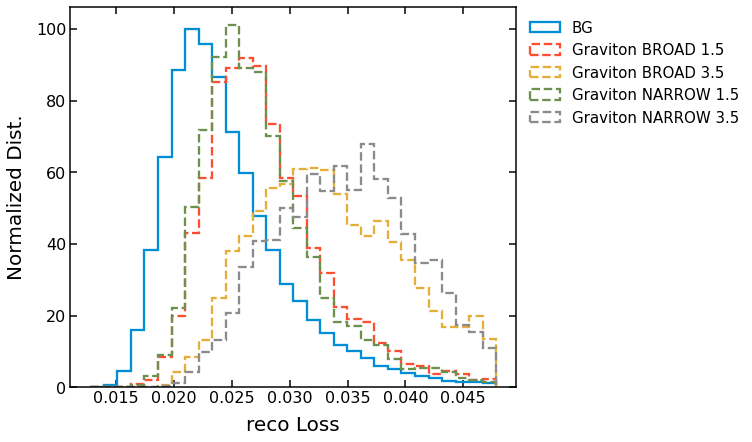

In [269]:
import matplotlib.pyplot as plt
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

for loss in [loss_bg_reco ]:
    max_score = 1.1*np.quantile(loss,0.99)
    min_score = np.min(loss)#,np.max(loss_bg_dist))
    bins = 30
    # plot BG
    plt.figure()
    plt.hist(loss, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2.3)
    for sig in signal_types:
        plt.hist(particles_sig_dict['loss'][sig], bins=bins, label=sig, density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=2.3)
    #plt.semilogy()
    plt.xlabel("reco Loss")
    plt.ylabel("Normalized Dist.")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.show()

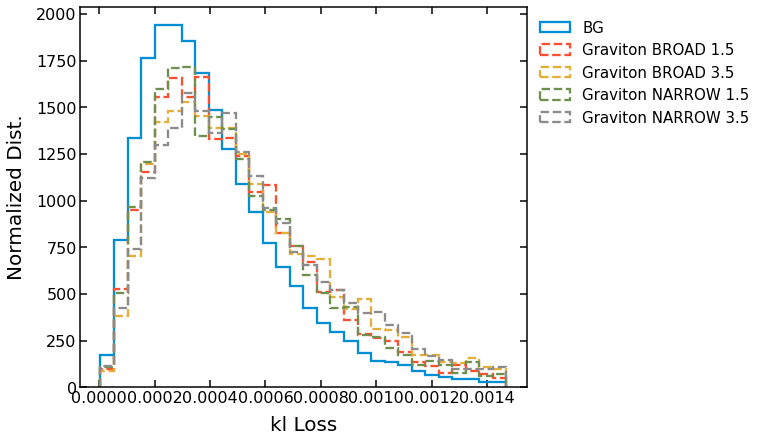

In [270]:
import matplotlib.pyplot as plt
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

for loss in [loss_bg_kl ]:
    max_score = 1.1*np.quantile(loss,0.99)
    min_score = np.min(loss)#,np.max(loss_bg_dist))
    bins = 30
    # plot BG
    plt.figure()
    plt.hist(loss, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2.3)
    for sig in signal_types:
        plt.hist(particles_sig_dict['loss_kl'][sig], bins=bins, label=sig, density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=2.3)
    #plt.semilogy()
    plt.xlabel("kl Loss")
    plt.ylabel("Normalized Dist.")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.show()

In [217]:
tf.data.experimental.cardinality(train_ds.batch(1,drop_remainder=True)).numpy()

2000

>>> Preparing training dataset generator


<module 'pofah.util.sample_factory' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/pofah/util/sample_factory.py'>

<module 'util.data_generator_particlenet' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/data_generator_particlenet.py'>

In [18]:
#data_train_generator_2 = dage_pn.DataGenerator(path=paths.sample_dir_path('qcdSide'), 
#                                         sample_part_n=params.gen_part_n, 
#                                          sample_max_n=params.train_total_n, 
#                                          **cuts.global_cuts) # generate 10 M jet samples



data_train_generator_new = dage_pn.DataGeneratorDirect(path=paths.sample_dir_path('qcdSide'), 
                                          sample_part_n=params.gen_part_n, 
                                          sample_max_n=params.train_total_n, 
                                          batch_size = 256,
                                          **cuts.global_cuts) # generate 10 M jet samples

In [19]:
#train_ds = tf.data.Dataset.from_generator(data_train_generator,
#                                     (tf.float32, tf.float32),
#                                     (tf.TensorShape([100,2]), tf.TensorShape([100,3]))
#                                         ).batch(params.batch_n, drop_remainder=True) # already shuffled

#train_ds_2 = tf.data.Dataset.from_generator(data_train_generator_2, 
 #                                         output_types=(tf.float32,tf.float32)).batch(params.batch_n, drop_remainder=True) # already shuffled


train_ds_2 = tf.data.Dataset.from_generator(data_train_generator_2, 
                                          output_types=(tf.float32,tf.float32)).batch(params.batch_n, drop_remainder=True) # already shuffled


NameError: name 'data_train_generator_2' is not defined

In [13]:
train_ds_2.take(1)

<TakeDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>

In [29]:
#new = train_ds_2.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
for data in train_ds_2.take(2):
    print(data)
    break

path =  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband_parts


/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/data_generator_particlenet.py:7: RuntimeWarning: divide by zero encountered in log
  return np.where(x==0,-10,np.log(x))


AttributeError: 'tuple' object has no attribute 'shape'

In [34]:
data_train_generator = dage.DataGenerator(path=paths.sample_dir_path('qcdSide'),
                                          sample_part_n=params.gen_part_n, 
                                          sample_max_n=params.train_total_n, 
                                          **cuts.global_cuts) # generate 10 M jet samples
train_ds = tf.data.Dataset.from_generator(data_train_generator, 
                                          output_types=tf.float32, 
                                          output_shapes=(100,3)).batch(params.batch_n, drop_remainder=True) # already shuffled


<TakeDataset shapes: (256, None, 100, 3), types: tf.float32>

In [11]:
generator = dare.DataReader(paths.sample_dir_path('qcdSide')).generate_event_parts_from_dir(parts_n=256, **cuts.global_cuts)

In [12]:
for constituents, features in generator:
    print(features.shape)
    break

(256, 11)


In [17]:
def our_generator():
    for i in range(1000):
      x = np.random.rand(28,28)
      y = np.random.randint(1,10, size=1)
      yield x,y

In [18]:
dataset = tf.data.Dataset.from_generator(our_generator, (tf.float32, tf.int16))


In [21]:
dataset = tf.data.Dataset.from_generator(our_generator, (tf.float32, tf.int16))


In [23]:
dataset = tf.data.Dataset.from_generator(our_generator, (tf.float32, tf.int16))
dataset = dataset.batch(batch_size=10)
dataset = dataset.repeat(count=2)

for batch, (x,y) in enumerate(dataset):
  pass
print("batch: ", batch)
print("Data shape: ", x.shape, y.shape)

batch:  199
Data shape:  (10, 28, 28) (10, 1)


In [25]:

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, x_col, y_col=None, batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.df = dataframe
        self.indices = self.df.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.x_col = x_col
        self.y_col = y_col
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        X = # logic
        y = # logic
        
        for i, id in enumerate(batch):
            X[i,] = # logic
            y[i] = # labels

        return X, y

SyntaxError: invalid syntax (<ipython-input-25-623889bf5d6e>, line 29)

In [6]:
import util.prepare_input as inp_prep
reload(inp_prep)

<module 'util.prepare_input' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/prepare_input.py'>

In [7]:
preparator = inp_prep.ParticleInputConversion(path=paths.sample_dir_path('qcdSide'),
                                          sample_part_n=params.gen_part_n, 
                                          outdir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based/',
                                          outname = 'test',
                                          **cuts.global_cuts)

In [ ]:
preparator.input_prep()

path =  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband_parts


/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/util/prepare_input.py:12: RuntimeWarning: divide by zero encountered in log
  return np.where(x==0,-10,np.log(x))


Writing 99995 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_0.h5 
Writing 99995 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_1.h5 
Writing 99995 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_2.h5 
Writing 99995 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_3.h5 
Writing 99992 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_4.h5 
Writing 99996 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_5.h5 
Writing 99995 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_6.h5 
Writing 99996 jets
Writing file /eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_based//test_7.h5 
Writing 

500000.0

In [ ]:
for i in data_train_generator_new():
    print(i)
    break

path =  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband_parts


In [ ]:
print('d')